# Local Setup Instructions

## Prerequisites Checklist

Before running this notebook, ensure you have completed the following setup:

- [ ] **Java 11 installed** and `JAVA_HOME` configured
  - macOS: `brew install openjdk@11`
  - Set: `export JAVA_HOME=$(/usr/libexec/java_home -v 11)`
- [ ] **Conda environment `fraud-shield` created and activated**
  - Create: `conda env create -f environment.yml`
  - Activate: `conda activate fraud-shield`
- [ ] **Data directories created**
  - `data/checkpoints/` - for EDA checkpoints
  - `data/processed/` - for processed data
  - `models/` - for saved models

## Environment Activation

```bash
conda activate fraud-shield
```

**Note:** This is a local execution version configured for the `fraud-shield` conda environment on your local machine.

# Feature Engineering & Selection for Fraud Detection

**Notebook:** 03-local-feature-engineering.ipynb  
**Objective:** Feature importance analysis, aggregated rankings, selection, and visualization using preprocessed data

**Pipeline:**
1. **Load:** Preprocessed train/val from `02-local-preprocessing.ipynb` (train_preprocessed.parquet, val_preprocessed.parquet).
2. **Feature importance:** RF, XGBoost, LightGBM, Mutual Information; each method yields importance scores and validation AUC.
3. **Aggregate rankings:** Combine scores into average rank and average (normalized) score; sort by rank; save `data/features/feature_rankings.csv`.
4. **Feature selection:** Top N features by aggregate rank (and optional min score); save `data/features/selected_features.pkl` and `feature_importance.pkl`.
5. **Visualization:** Per-method bar charts and aggregated top-k bar chart; save to `data/features/` (e.g. feature_importance_plots.png, aggregated_feature_importance.png).

**Outputs:** feature_rankings.csv, selected_features.pkl, feature_importance.pkl, plots. Downstream: notebook 04 uses these for iterative model training.

**Note:** Local execution - conda environment `fraud-shield`

In [1]:
# ============================================================
# GLOBAL IMPORTS & DEPENDENCIES
# ============================================================

import os
import sys
from pathlib import Path
from typing import Tuple, List, Dict, Optional
import warnings
warnings.filterwarnings('ignore')

# Data Processing
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve
import xgboost as xgb
import lightgbm as lgb

# Feature Selection
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
import pickle
import joblib

print("All dependencies loaded successfully")

All dependencies loaded successfully


In [2]:
# ============================================================
# CONFIGURATION & PATHS
# ============================================================

# Path resolution for local execution
NOTEBOOK_DIR = Path.cwd()
if NOTEBOOK_DIR.name == "local_notebooks":
    PROJECT_ROOT = NOTEBOOK_DIR.parent
else:
    PROJECT_ROOT = NOTEBOOK_DIR

os.chdir(PROJECT_ROOT)

DATA_DIR = PROJECT_ROOT / "data"
PROCESSED_DATA_DIR = DATA_DIR / "processed"
MODELS_DIR = PROJECT_ROOT / "models"
FEATURES_DIR = DATA_DIR / "features"

# Create directories if they don't exist
MODELS_DIR.mkdir(exist_ok=True)
FEATURES_DIR.mkdir(exist_ok=True)

# Data paths
PREPROCESSED_TRAIN_PATH = PROCESSED_DATA_DIR / 'train_preprocessed.parquet'
PREPROCESSED_VAL_PATH = PROCESSED_DATA_DIR / 'val_preprocessed.parquet'
FEATURE_NAMES_PATH = MODELS_DIR / 'feature_names.pkl'

# Output paths
FEATURE_IMPORTANCE_PATH = FEATURES_DIR / 'feature_importance.pkl'
SELECTED_FEATURES_PATH = FEATURES_DIR / 'selected_features.pkl'
FEATURE_RANKINGS_PATH = FEATURES_DIR / 'feature_rankings.csv'

print(f"Project root: {PROJECT_ROOT}")
print(f"Data directory: {DATA_DIR}")
print(f"Processed data directory: {PROCESSED_DATA_DIR}")
print(f"Features directory: {FEATURES_DIR}")
print(f"Models directory: {MODELS_DIR}")

Project root: /Users/abzanganeh/Desktop/projects/fraud-shield-ai
Data directory: /Users/abzanganeh/Desktop/projects/fraud-shield-ai/data
Processed data directory: /Users/abzanganeh/Desktop/projects/fraud-shield-ai/data/processed
Features directory: /Users/abzanganeh/Desktop/projects/fraud-shield-ai/data/features
Models directory: /Users/abzanganeh/Desktop/projects/fraud-shield-ai/models


## Section 1: Load Preprocessed Data

Load the preprocessed training and validation data from the preprocessing notebook.

In [3]:
# ============================================================
# LOAD PREPROCESSED DATA
# ============================================================

def load_preprocessed_data() -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Load preprocessed training and validation data.
    
    Returns:
        Tuple of (train_df, val_df) as pandas DataFrames
    """
    if not PREPROCESSED_TRAIN_PATH.exists():
        raise FileNotFoundError(
            f"Preprocessed data not found: {PREPROCESSED_TRAIN_PATH}\n"
            "Please run 02-local-preprocessing.ipynb first."
        )
    
    print("Loading preprocessed data...")
    train_df = pd.read_parquet(PREPROCESSED_TRAIN_PATH)
    val_df = pd.read_parquet(PREPROCESSED_VAL_PATH)
    
    print(f"✓ Training data loaded: {len(train_df):,} samples, {train_df.shape[1]} features")
    print(f"✓ Validation data loaded: {len(val_df):,} samples, {val_df.shape[1]} features")
    
    # Separate features and target
    X_train = train_df.drop(columns=['is_fraud'])
    y_train = train_df['is_fraud']
    X_val = val_df.drop(columns=['is_fraud'])
    y_val = val_df['is_fraud']
    
    print(f"\nFeature matrix shape:")
    print(f"  Train: {X_train.shape}")
    print(f"  Validation: {X_val.shape}")
    print(f"\nTarget distribution:")
    print(f"  Train - Fraud: {y_train.sum():,} ({y_train.mean():.4%})")
    print(f"  Validation - Fraud: {y_val.sum():,} ({y_val.mean():.4%})")
    
    return X_train, y_train, X_val, y_val


# Load data
X_train, y_train, X_val, y_val = load_preprocessed_data()
feature_names = X_train.columns.tolist()
print(f"\nTotal features: {len(feature_names)}")

Loading preprocessed data...
✓ Training data loaded: 1,131,931 samples, 25 features
✓ Validation data loaded: 122,480 samples, 25 features

Feature matrix shape:
  Train: (1131931, 24)
  Validation: (122480, 24)

Target distribution:
  Train - Fraud: 102,902 (9.0908%)
  Validation - Fraud: 643 (0.5250%)

Total features: 24


## Section 2: Feature Importance Analysis

Analyze feature importance using multiple methods:
1. Random Forest feature importance
2. XGBoost feature importance
3. LightGBM feature importance
4. Statistical feature selection (mutual information)

In [4]:
# ============================================================
# FEATURE IMPORTANCE ANALYSIS
# ============================================================

def calculate_feature_importance(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_val: pd.DataFrame,
    y_val: pd.Series,
    feature_names: List[str]
) -> Dict[str, pd.DataFrame]:
    """
    Calculate feature importance using multiple methods.
    
    Returns:
        Dictionary with importance scores from different methods
    """
    importance_scores = {}
    
    print("Calculating feature importance using multiple methods...\n")
    
    # 1. Random Forest
    print("1. Training Random Forest...")
    rf = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=1000,
        min_samples_leaf=500,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1,
        verbose=0
    )
    rf.fit(X_train, y_train)
    rf_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)
    importance_scores['random_forest'] = rf_importance
    print(f"   ✓ Random Forest AUC: {roc_auc_score(y_val, rf.predict_proba(X_val)[:, 1]):.4f}")
    
    # 2. XGBoost
    print("2. Training XGBoost...")
    xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]),
        random_state=42,
        n_jobs=-1,
        verbosity=0
    )
    xgb_model.fit(X_train, y_train)
    xgb_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': xgb_model.feature_importances_
    }).sort_values('importance', ascending=False)
    importance_scores['xgboost'] = xgb_importance
    print(f"   ✓ XGBoost AUC: {roc_auc_score(y_val, xgb_model.predict_proba(X_val)[:, 1]):.4f}")
    
    # 3. LightGBM
    print("3. Training LightGBM...")
    lgb_model = lgb.LGBMClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]),
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )
    lgb_model.fit(X_train, y_train)
    lgb_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': lgb_model.feature_importances_
    }).sort_values('importance', ascending=False)
    importance_scores['lightgbm'] = lgb_importance
    print(f"   ✓ LightGBM AUC: {roc_auc_score(y_val, lgb_model.predict_proba(X_val)[:, 1]):.4f}")
    
    # 4. Mutual Information
    print("4. Calculating Mutual Information...")
    mi_scores = mutual_info_classif(X_train, y_train, random_state=42)
    mi_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': mi_scores
    }).sort_values('importance', ascending=False)
    importance_scores['mutual_info'] = mi_importance
    print("   ✓ Mutual Information calculated")
    
    return importance_scores


# Calculate importance scores
importance_scores = calculate_feature_importance(X_train, y_train, X_val, y_val, feature_names)

Calculating feature importance using multiple methods...

1. Training Random Forest...
   ✓ Random Forest AUC: 0.9198
2. Training XGBoost...
   ✓ XGBoost AUC: 0.9282
3. Training LightGBM...
   ✓ LightGBM AUC: 0.9273
4. Calculating Mutual Information...
   ✓ Mutual Information calculated


## Section 3: Aggregate Feature Rankings

Combine importance scores from all methods to create a unified feature ranking.

In [5]:
# ============================================================
# AGGREGATE FEATURE RANKINGS
# ============================================================

def aggregate_rankings(importance_scores: Dict[str, pd.DataFrame]) -> pd.DataFrame:
    """
    Aggregate feature rankings from multiple methods.
    
    Returns:
        DataFrame with aggregated rankings and scores
    """
    # Create a combined DataFrame
    combined = pd.DataFrame({'feature': feature_names})
    
    # Add normalized importance scores from each method
    for method, df in importance_scores.items():
        # Create a mapping from feature to rank (1 = most important)
        df_sorted = df.sort_values('importance', ascending=False).reset_index(drop=True)
        rank_map = {feat: idx + 1 for idx, feat in enumerate(df_sorted['feature'])}
        score_map = {feat: score for feat, score in zip(df['feature'], df['importance'])}
        
        combined[f'{method}_score'] = combined['feature'].map(score_map)
        combined[f'{method}_rank'] = combined['feature'].map(rank_map)
    
    # Calculate average rank (lower is better)
    rank_cols = [col for col in combined.columns if col.endswith('_rank')]
    combined['avg_rank'] = combined[rank_cols].mean(axis=1)
    
    # Calculate average normalized score (higher is better)
    score_cols = [col for col in combined.columns if col.endswith('_score')]
    combined['avg_score'] = combined[score_cols].mean(axis=1)
    
    # Sort by average rank
    combined = combined.sort_values('avg_rank').reset_index(drop=True)
    
    return combined


# Create aggregated rankings
feature_rankings = aggregate_rankings(importance_scores)

print("Top 15 Features by Average Rank:")
print(feature_rankings[['feature', 'avg_rank', 'avg_score']].head(15).to_string(index=False))

# Save rankings
feature_rankings.to_csv(FEATURE_RANKINGS_PATH, index=False)
print(f"\n✓ Feature rankings saved: {FEATURE_RANKINGS_PATH}")

Top 15 Features by Average Rank:
feature  avg_rank  avg_score
     21      2.25 136.384510
     23      4.00 146.831405
      6      6.50  96.797648
     16      6.75  20.383913
     12      7.25  18.099399
      7      7.25  72.547410
     11      7.50  20.551984
      2      8.00  46.052363
     22      8.75  63.312620
     20     10.00   5.794265
      8     10.25  77.283270
     17     11.00   4.543094
      3     12.00   6.043996
     13     12.25   1.287500
      0     13.00  10.769401

✓ Feature rankings saved: /Users/abzanganeh/Desktop/projects/fraud-shield-ai/data/features/feature_rankings.csv


## Section 4: Feature Selection

Select top features based on importance rankings and validate performance.

In [6]:
# ============================================================
# FEATURE SELECTION
# ============================================================

def select_top_features(
    feature_rankings: pd.DataFrame,
    n_features: int = 20,
    min_score: float = 0.01
) -> List[str]:
    """
    Select top features based on rankings and minimum score threshold.
    
    Args:
        feature_rankings: DataFrame with feature rankings
        n_features: Maximum number of features to select
        min_score: Minimum average score threshold
    
    Returns:
        List of selected feature names
    """
    # Filter by minimum score
    filtered = feature_rankings[feature_rankings['avg_score'] >= min_score]
    
    # Select top N features
    selected = filtered.head(n_features)['feature'].tolist()
    
    print(f"Feature Selection Summary:")
    print(f"  Total features: {len(feature_rankings)}")
    print(f"  Features above threshold ({min_score}): {len(filtered)}")
    print(f"  Selected top {n_features} features")
    print(f"\nSelected features:")
    for i, feat in enumerate(selected, 1):
        rank = feature_rankings[feature_rankings['feature'] == feat]['avg_rank'].values[0]
        score = feature_rankings[feature_rankings['feature'] == feat]['avg_score'].values[0]
        print(f"  {i:2d}. {feat:30s} (rank: {rank:.1f}, score: {score:.4f})")
    
    return selected


# Select top features
selected_features = select_top_features(feature_rankings, n_features=20, min_score=0.01)

# Save selected features
with open(SELECTED_FEATURES_PATH, 'wb') as f:
    pickle.dump(selected_features, f)
print(f"\n✓ Selected features saved: {SELECTED_FEATURES_PATH}")

# Save importance scores
with open(FEATURE_IMPORTANCE_PATH, 'wb') as f:
    pickle.dump(importance_scores, f)
print(f"✓ Feature importance scores saved: {FEATURE_IMPORTANCE_PATH}")

Feature Selection Summary:
  Total features: 24
  Features above threshold (0.01): 20
  Selected top 20 features

Selected features:
   1. 21                             (rank: 2.2, score: 136.3845)
   2. 23                             (rank: 4.0, score: 146.8314)
   3. 6                              (rank: 6.5, score: 96.7976)
   4. 16                             (rank: 6.8, score: 20.3839)
   5. 12                             (rank: 7.2, score: 18.0994)
   6. 7                              (rank: 7.2, score: 72.5474)
   7. 11                             (rank: 7.5, score: 20.5520)
   8. 2                              (rank: 8.0, score: 46.0524)
   9. 22                             (rank: 8.8, score: 63.3126)
  10. 20                             (rank: 10.0, score: 5.7943)
  11. 8                              (rank: 10.2, score: 77.2833)
  12. 17                             (rank: 11.0, score: 4.5431)
  13. 3                              (rank: 12.0, score: 6.0440)
  14. 13           

## Section 5: Feature Visualization

Visualize feature importance rankings from different methods.

✓ Feature importance plots saved: /Users/abzanganeh/Desktop/projects/fraud-shield-ai/data/features/feature_importance_plots.png


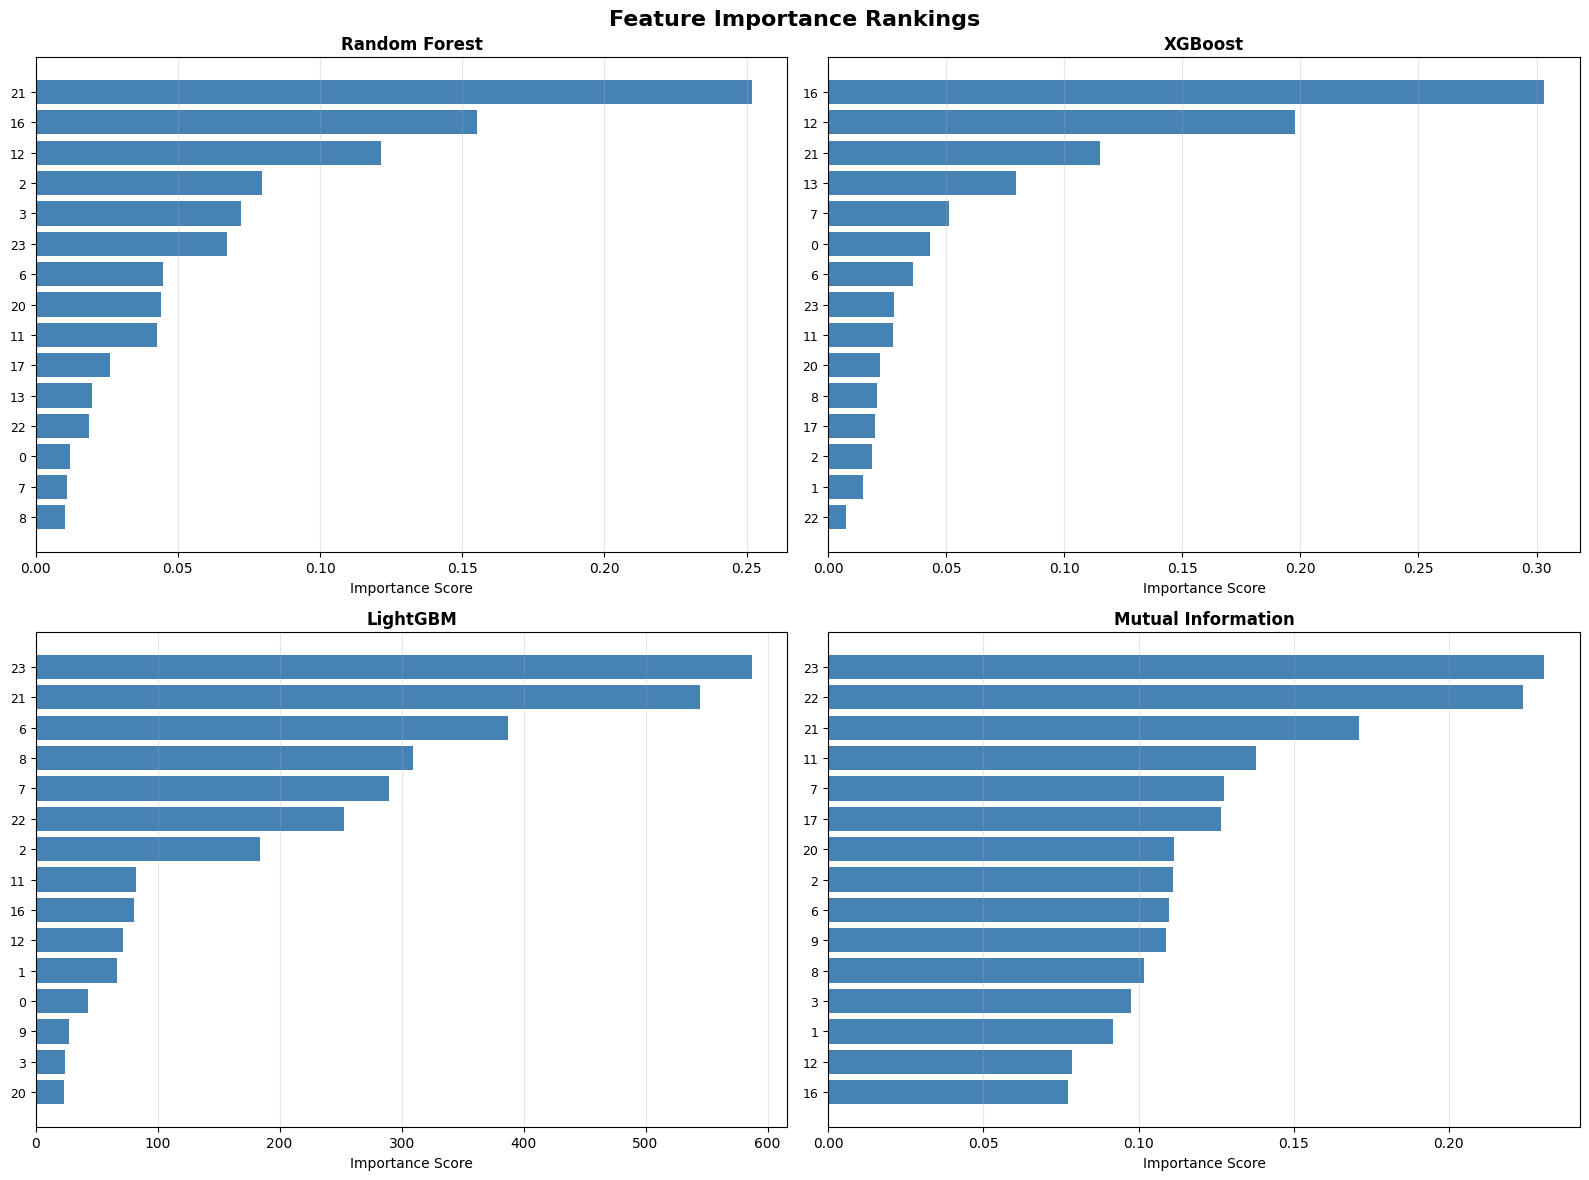

✓ Aggregated feature importance plot saved: /Users/abzanganeh/Desktop/projects/fraud-shield-ai/data/features/aggregated_feature_importance.png


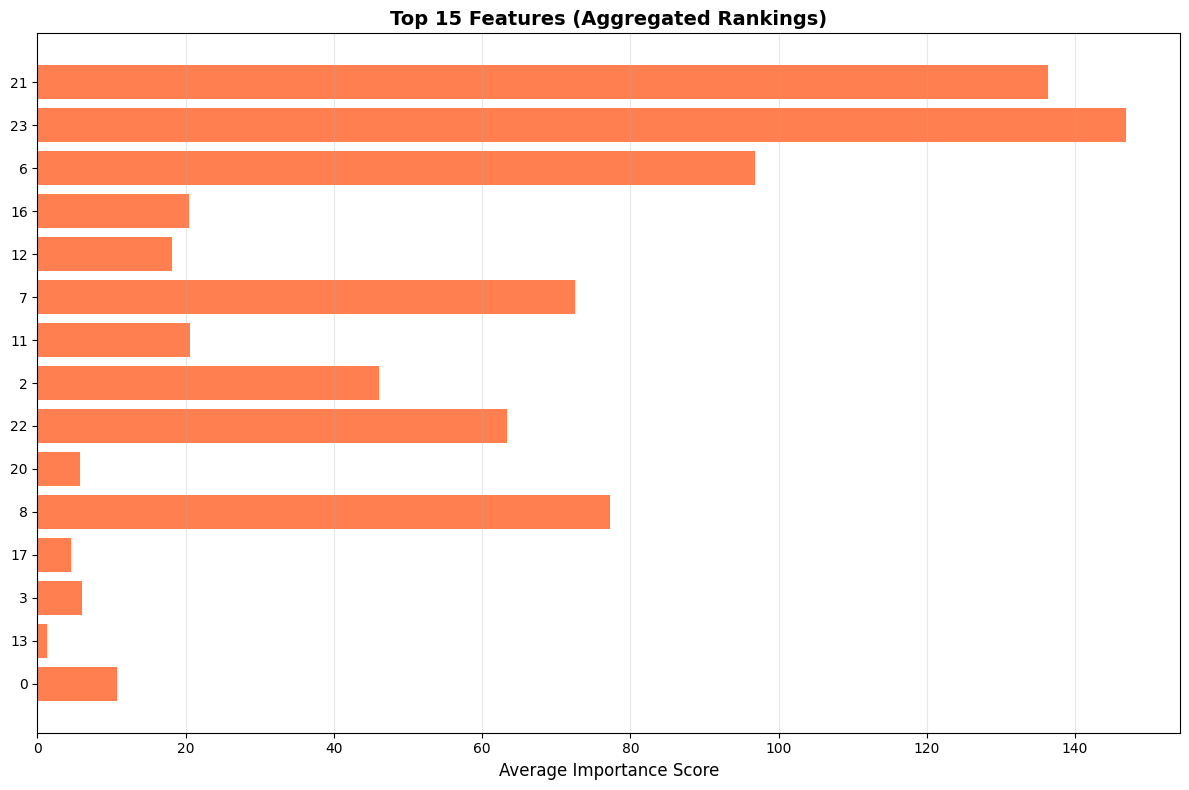

In [7]:
# ============================================================
# VISUALIZE FEATURE IMPORTANCE
# ============================================================

def plot_feature_importance(
    importance_scores: Dict[str, pd.DataFrame],
    feature_rankings: pd.DataFrame,
    top_n: int = 15
):
    """Plot feature importance from different methods."""
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Feature Importance Rankings', fontsize=16, fontweight='bold')
    
    methods = ['random_forest', 'xgboost', 'lightgbm', 'mutual_info']
    titles = ['Random Forest', 'XGBoost', 'LightGBM', 'Mutual Information']
    
    for idx, (method, title) in enumerate(zip(methods, titles)):
        ax = axes[idx // 2, idx % 2]
        df = importance_scores[method].head(top_n)
        
        ax.barh(range(len(df)), df['importance'].values, color='steelblue')
        ax.set_yticks(range(len(df)))
        ax.set_yticklabels(df['feature'].values, fontsize=9)
        ax.set_xlabel('Importance Score', fontsize=10)
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.invert_yaxis()
        ax.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(FEATURES_DIR / 'feature_importance_plots.png', dpi=150, bbox_inches='tight')
    print(f"✓ Feature importance plots saved: {FEATURES_DIR / 'feature_importance_plots.png'}")
    plt.show()
    
    # Plot aggregated rankings
    plt.figure(figsize=(12, 8))
    top_features = feature_rankings.head(top_n)
    plt.barh(range(len(top_features)), top_features['avg_score'].values, color='coral')
    plt.yticks(range(len(top_features)), top_features['feature'].values)
    plt.xlabel('Average Importance Score', fontsize=12)
    plt.title(f'Top {top_n} Features (Aggregated Rankings)', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.savefig(FEATURES_DIR / 'aggregated_feature_importance.png', dpi=150, bbox_inches='tight')
    print(f"✓ Aggregated feature importance plot saved: {FEATURES_DIR / 'aggregated_feature_importance.png'}")
    plt.show()


# Create visualizations
plot_feature_importance(importance_scores, feature_rankings, top_n=15)

## Section Summary

**Pipeline (Sections 1–5):** Load preprocessed train/val; feature importance (RF, XGBoost, LightGBM, Mutual Information); aggregate rankings; select top N features; save and visualize.

**Outputs:**
- `data/features/feature_rankings.csv` – aggregated rankings
- `data/features/feature_importance.pkl` – per-method importance scores
- `data/features/selected_features.pkl` – selected feature list
- `data/features/feature_importance_plots.png` – per-method bar charts
- `data/features/aggregated_feature_importance.png` – top-k aggregated bar chart

**Next:** Use in 04-local-supervised-models.ipynb (e.g. load `feature_rankings.csv` for iterative feature order or `selected_features.pkl` for the feature list).